In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.functional as F
from io import open
from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import pathlib
!pip install patool
import patoolib
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [60]:
if not os.path.exists('./TL_dataset'):
    patoolib.extract_archive('TL_dataset.zip')

In [61]:
# Extracting the dataset and creating the train and test folders
data_dir = pathlib.Path('TL_dataset')
classes = os.listdir(data_dir)
print('classes: ',classes)

#do K fold creation here...

# Creating the train and validation folders
if not os.path.exists('./splited_dataset'):
    os.makedirs('./splited_dataset/train')
    os.makedirs('./splited_dataset/val')

    # Creating the class folders in train and validation folders
    for i in classes:
        os.makedirs('./splited_dataset/train/' + i)
        os.makedirs('./splited_dataset/val/' + i)

random.seed(0)

# Splitting the dataset into train and test sets
for i in classes:
    src = "./TL_dataset/" + i # Folder to copy images from
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)

    train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)*0.8)])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        # print(name)
        shutil.copy(name, "./splited_dataset/train/" + i)
    for name in val_FileNames:
        shutil.copy(name, "./splited_dataset/val/" + i)

classes:  ['2', '1', '3']
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9
Total images:  42
Training:  33
Validation:  9


In [62]:
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224,0.225])

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((30, 30)),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel grayscale image three times to create an RGB image
        transforms.Normalize(mean, std)  # Normalize all three channels
    ]),
    'val':transforms.Compose([
        transforms.Resize((30, 30)),
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel grayscale image three times to create an RGB image
        transforms.Normalize(mean, std)  # Normalize all three channels
    ])
}

In [63]:
data_dir = 'splited_dataset'
sets = ['train','val']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir,x),
                                         data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=4)
                for x in ['train','val']}


In [64]:
dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
print(class_names)

['1', '2', '3']


In [65]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #save the model with best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'bestFineTuneModel.model')


        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    #load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [66]:
#VoltaVision-3
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()

        # Input shape = (64, 3, 30, 30)
        # Output size after convolutional layer = (w-f+2p)/s + 1 = (30-3+2)/1 + 1 = 30
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Input shape = (64, 12, 30, 30)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()

        # Input shape = (64, 12, 30, 30)
        # Output size after max pooling = 30/2 = 15
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Input shape = (64, 12, 15, 15)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        #shape = (64, 32, 15, 15)

        self.fc = nn.Linear(in_features=15*15*32, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.maxpool1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        #reshaping the output to feed into the fully connected layer
        output = output.view(-1, 15*15*32)

        output = self.fc(output)

        return output

Epoch 0/24
----------
train Loss: 0.7167 Acc: 0.7460
val Loss: 0.4191 Acc: 0.8763

Epoch 1/24
----------
train Loss: 0.4149 Acc: 0.8730
val Loss: 0.2677 Acc: 0.9588

Epoch 2/24
----------
train Loss: 0.2950 Acc: 0.9127
val Loss: 0.2312 Acc: 0.9381

Epoch 3/24
----------
train Loss: 0.2026 Acc: 0.9762
val Loss: 0.1687 Acc: 0.9897

Epoch 4/24
----------
train Loss: 0.1791 Acc: 0.9841
val Loss: 0.1601 Acc: 0.9897

Epoch 5/24
----------
train Loss: 0.1781 Acc: 0.9762
val Loss: 0.1276 Acc: 0.9897

Epoch 6/24
----------
train Loss: 0.1422 Acc: 0.9841
val Loss: 0.1222 Acc: 0.9897

Epoch 7/24
----------
train Loss: 0.1340 Acc: 0.9762
val Loss: 0.1068 Acc: 0.9897

Epoch 8/24
----------
train Loss: 0.1038 Acc: 0.9921
val Loss: 0.1125 Acc: 0.9897

Epoch 9/24
----------
train Loss: 0.1155 Acc: 0.9921
val Loss: 0.1040 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1024 Acc: 0.9841
val Loss: 0.1084 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1148 Acc: 0.9841
val Loss: 0.1003 Acc: 1.0000

Ep

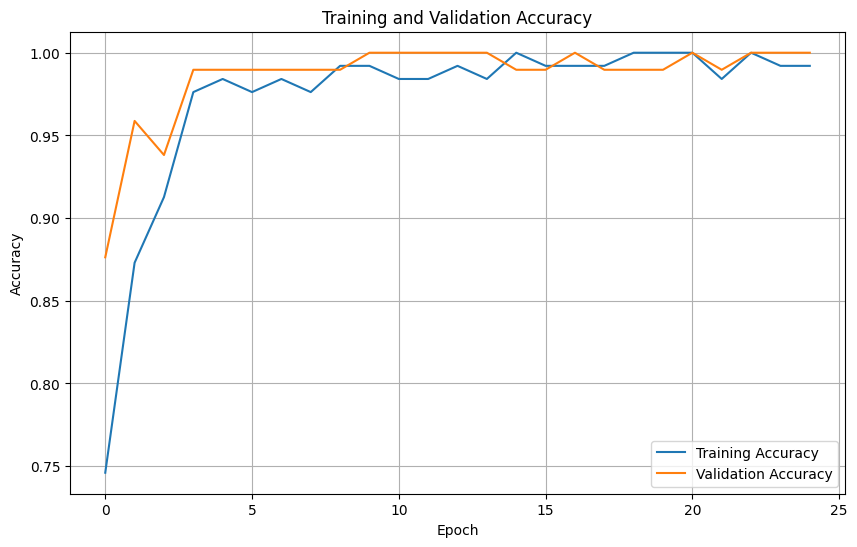

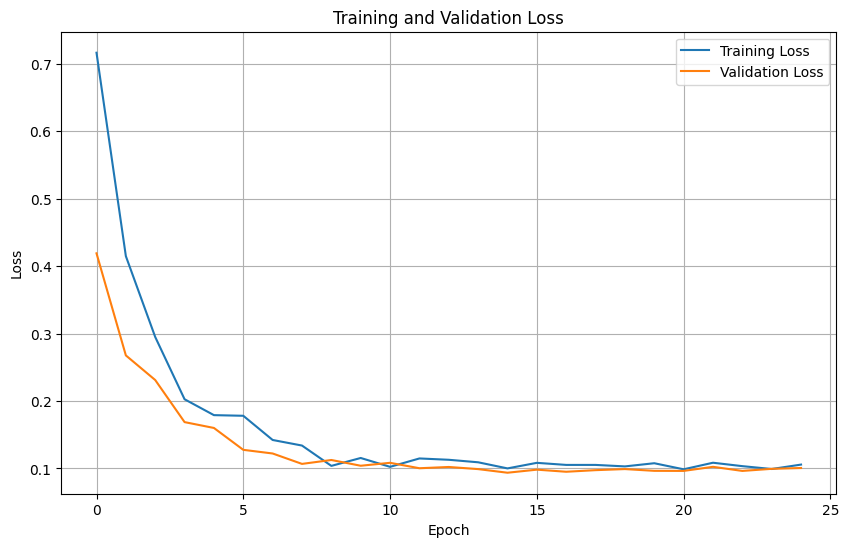

In [67]:
#load the best_checkpoint.model
checkpoint = torch.load('custom_cnn_best_checkpoint.model')
pretrained_model = ConvNet(num_classes=3)
pretrained_model.load_state_dict(checkpoint)

for param in pretrained_model.parameters():
    param.requires_grad = False

#exchange the last layer
num_ftrs = pretrained_model.fc.in_features

pretrained_model.fc = nn.Linear(num_ftrs, 3)
pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(),lr=0.001)

#scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

model_ft = train_model(pretrained_model,criterion,optimizer,step_lr_scheduler,num_epochs=25)